In this notebook, a lightweight pretrained model [albert](https://arxiv.org/abs/1909.11942) is finetuned on cola dataset, using three semisupervised training method: (i) [PiModel](https://arxiv.org/abs/1610.02242), (ii) [Temporal Ensembling](https://arxiv.org/abs/1610.02242) and (iii) [Co-Training](https://arxiv.org/abs/1610.02242) using ssfinetuning package.


We will perform three steps for each model:

1. Installation
2. Training 
3. Plotting the results using ssfinetuning plotter.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install ssfinetuning
#!pip3 install ssfinetuningV2
#!pip install ssfinetuning==0.2.1

#!git clone https://github.com/shafir360/ssfinetuningV2
#!sudo python /content/ssfinetuningV2/setup.py install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers
!pip install datasets
!pip install sentencepiece
#!pip install wandb
import json
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd




import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
from datasets import Dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from datasets import load_dataset, load_metric
from ssfinetuning import train_with_ssl

Downloading cola dataset via HuggingFace's [datasets](https://github.com/huggingface/datasets) library.

Setting the seed value for reproducible results.

In [ ]:

torch.manual_seed(970)
torch.cuda.manual_seed_all(970)

In [ ]:
import pandas as pd
input = '/content/drive/MyDrive/fyp/fyp2/labelled data concat/full_labelled_data.csv'
input_unlabelled = '/content/drive/MyDrive/fyp/fyp2/tweets16m_cleaned.csv.csv'
model_name = "svalabs/twitter-xlm-roberta-bitcoin-sentiment"
#model_name = "xlm-roberta-base"
name_of_text_column = "text"

df_ = pd.read_csv(input)
df_unlabelled_ = pd.read_csv(input_unlabelled)
display(df_)
display(df_unlabelled_)

#df_test = df_.merge(on = 'text')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,text,label
0,0,🔥🔥🔥 ANOTHER MASSIVE WIN! 🔥🔥🔥\n\nLUNA/USD Take-...,Positive
1,1,&gt;There is no inflation\n&gt;There is some i...,Neutral
2,2,China’s largest broadcaster’s NFT series becom...,Neutral
3,3,❗Bee Network-Cloud Mining on Your Phone ❗☁️⛏️💰...,Neutral
4,4,"Have you heard of $PIT, one of the largest com...",Positive
...,...,...,...
460,460,the strongest bullish signal flashed for Bitco...,Positive
461,461,the strongest bullish signal flashed for Bitco...,Positive
462,462,whre is the $dot whales\ndont miss these coins...,Positive
463,463,you are always talking about Bitcoin but MarkM...,Neutral


,date,date.1,tweet,lang
0,2017-01-01,2017-01-01 10:30:10+00,2814 BTC],en
1,2017-01-01,2017-01-01 10:30:04+00,One Bitcoin now worth $975.00. High $975.00. L...,en
2,2017-01-01,2017-01-01 10:30:06+00,8BitCoin 8BIT $0.011464 (0.86%) 0.00001195 BTC...,en
3,2017-01-01,2017-01-01 10:23:44+00,Bitcoin last trade\n\n $976.81\n $939.00\n\nSe...,en
4,2017-01-01,2017-01-01 10:30:20+00,$977.38 bitfinex;\n$974.98 GDAX;\n$975.00 bits...,en
...,...,...,...,...
11299370,2019-11-23,2019-11-23 05:40:39+00,"Bitcoin price 7238.65641481, DOWN -4.74 percen...",en
11299371,2019-11-23,2019-11-23 05:40:02+00,A $XMR is worth 0.00696045 BTC,en
11299372,2019-11-23,2019-11-23 05:40:03+00,"Top 5 cryptocurrencies \n03\n $7,234.439\n $15...",en
11299373,2019-11-23,2019-11-23 05:39:53+00,"Arbistar 2.0, llamada de éxito 20/11, bots for...",en


In [ ]:
#df_t = pd.read_csv("/content/drive/MyDrive/fyp/fyp2/Bitcoin_tweets_cleaned.csv")
#df_t = pd.read_csv("/content/drive/MyDrive/fyp/fyp2/tweets16m_cleaned.csv.csv")
#display(df_t)

In [ ]:
#df1 = df_.drop_duplicates(subset=['text'])
#df1 = pd.read_csv("/content/drive/MyDrive/fyp/fyp2/sliced cleaned data/labellingdata28.csv")
#display(df1)
#df2 = df_unlabelled_
#df2 = df_t.copy()
#df_m = df1.merge(df2, left_on='tweet', right_on='tweet')
#df_m.drop_duplicates(inplace = True,subset=['text'])
#df_m.drop_duplicates(inplace = True,subset=['tweet'])
#display(df_m)
##turks different due to less emoji

In [ ]:
def match_with_batchsize(lim, batchsize):
    """
    Function used by modify_datasets below to match return the integer closest to lim
    which is multiple of batchsize, i.e., lim%batchsize=0.
    """

    if lim % batchsize == 0:
        return lim
    else:
        return lim - lim % batchsize

34 13 91


Dataset({
    features: ['sentence', 'label'],
    num_rows: 326
})

Dataset({
    features: ['sentence', 'label'],
    num_rows: 10822072
})

<class 'datasets.dataset_dict.DatasetDict'>
DatasetDict({
    labeled: Dataset({
        features: ['sentence', 'label'],
        num_rows: 326
    })
    validation: Dataset({
        features: ['index', 'sentence', 'label'],
        num_rows: 138
    })
    unlabeled: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10822072
    })
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10822398
    })
})


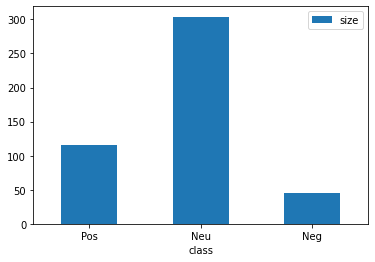

In [ ]:
import datasets
from datasets import concatenate_datasets, DatasetDict
valid_percentage = 0.3
batch_size = 2
reduce_ = False



df = df_.copy()

df_unlabelled = df_unlabelled_.copy()

if reduce_:
  df_unlabelled = df_unlabelled[0:1000]


#valid_size_each_class = int(df.shape[0] * valid_percentage)
df_unlabelled = df_unlabelled.rename(columns={"tweet": "sentence"})
df_unlabelled['label'] = -1
df_unlabelled = df_unlabelled[['sentence', 'label']]
df_unlabelled = df_unlabelled.dropna()
#display(df_unlabelled)

#print(valid_size_each_class)

sentences = df['text'].copy().to_list()
labels = []
urls = []

def ConvertLabel2ModelLabel(label):
  if label == 'Positive':
    o = 2
  elif label == 'Neutral':
    o = 1
  elif label == 'Negative':
    o = 0
  elif label == 'spam':
    o = 1
  else: 
    print(" error at ConvertLabel2ModelLabel label is " , label)
    o = np.nan
  return o


df['label'] = df.label.apply(lambda x : ConvertLabel2ModelLabel(x) )
df = df[['text','label']]
df = df.rename(columns={"text": "sentence"})
#display(df)




df_pos = df[df['label'] == 2].sample(frac=1).reset_index(drop=False)
df_neg = df[df['label'] == 0].sample(frac=1).reset_index(drop=True)
df_neu = df[df['label'] == 1].sample(frac=1).reset_index(drop=True)

data = []

distri_class = pd.DataFrame({'class':['Pos', 'Neu', 'Neg'], 'size':[df_pos.shape[0], df_neu.shape[0], df_neg.shape[0]]})
ax = distri_class.plot.bar(x='class', y='size', rot=0)

valid_size_class_pos = int(df_pos.shape[0] * valid_percentage)
valid_size_class_neg = int(df_neg.shape[0] * valid_percentage)
valid_size_class_neu = int(df_neu.shape[0] * valid_percentage)

print(valid_size_class_pos,valid_size_class_neg,valid_size_class_neu)




validation_dataset = df_pos[0:valid_size_class_pos]
validation_dataset = validation_dataset.append(df_neg[0:valid_size_class_neg])
validation_dataset = validation_dataset.append(df_neu[0:valid_size_class_neu])
validation_dataset = validation_dataset.sample(frac=1).reset_index(drop=True)
validation_dataset = Dataset.from_dict(validation_dataset)

labelled = df_pos[valid_size_class_pos:]
labelled = labelled.append(df_neg[valid_size_class_neg:])
labelled = labelled.append(df_neu[valid_size_class_neu:])
labelled = labelled[0 : match_with_batchsize(labelled.shape[0],batch_size) ]
labelled = labelled.sample(frac=1).reset_index(drop=True)
labelled = labelled.drop(columns = 'index')
labelled =  Dataset.from_dict(labelled)


df_unlabelled = df_unlabelled[ 0 : match_with_batchsize(df_unlabelled.shape[0],batch_size) ]
df_unlabelled = df_unlabelled.sample(frac=1).reset_index(drop=True)
unlabelled = Dataset.from_dict(df_unlabelled)


dataset = datasets.DatasetDict({"labeled":labelled,"validation":validation_dataset,'unlabeled':unlabelled})
display(dataset['labeled'],dataset['unlabeled'])
dataset['train'] = concatenate_datasets([dataset['labeled'], dataset['unlabeled']])



print(type(dataset))
print(dataset)

In [ ]:
import pandas as pd
data={'Age':list(range(1, 1001))}
#batchsize = 16
df_test=pd.DataFrame(data)
df_test = df_test[10:12]

display(df_test)



def match_with_batchsize(lim, batchsize):
    """
    Function used by modify_datasets below to match return the integer closest to lim
    which is multiple of batchsize, i.e., lim%batchsize=0.
    """

    if lim % batchsize == 0:
        return lim
    else:
        return lim - lim % batchsize

print(match_with_batchsize(33,16))

,Age
10,11
11,12


32


# FineTuning with PiModel

## Options chosen for training in this example.

1. labeled_fraction: This is the list which divides the dataset into different labeled fractions mentioned as the list elements. For example,
if a list of `labeled_fraction` is set as below, the function `train_with_ssl` will first keep the 15% of data as labeled and consider the rest as unlabeled and apply all the combinations of hyperparmeters to obtain the results. Then, it will do the same by keeping 35% of the labels and so on.  

2. use_sup: This is whether the trainer should first train a supervised model and then use that trained model as an starting point for the ssl training.

3. dataset: Huggingface dataset.

4. model_name: NLP transformers model name as used by huggingface library. See this [page](https://huggingface.co/transformers/pretrained_models.html) for more information.

5. arg_ta = `transformers.TrainingArguments`, check this [page](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments) for information. If using `train_with_ssl` then, there are default values setup in `default_args` module. These values are similar to this [notebook](https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb) since cola dataset has been used here. If you would like to keep all the other arguments [same](https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb) as this notebook but changed only few, it could be changed with using arg_ta as dictionary and changing that specific argument like below. Otherwise you can also a prepare whole new TrainingArguments object. 

6. arg_ta_sup: Similar to `arg_ta`, but for supervised model, if `use_sup` or `run_sup` has been enabled.

7. ssl_model_type: Semisupervised model type.

**`unsup_hp`**:

This is a dictionary of hyperparameter that you would like test you ssl model against. For example, in the case of PiModel the choices could be:

- **w_ramprate**: linear rate at which the unsupervised weight would be increased from the initial value.
- **update_weights_steps:** interval steps after which unsupervised weight
would be updated by the w_ramprate etc.
 
Please look at [`PiModel`](https://ssfinetuning.readthedocs.io/en/latest/ssfinetuning.html#ssfinetuning.models.PiModel) or [`TrainerWithUWScheduler`](https://ssfinetuning.readthedocs.io/en/latest/ssfinetuning.html#ssfinetuning.trainer_util.TrainerWithUWScheduler) documentation for more information. 
In this example we only use vary `w_ramprate`. 

In [ ]:
!nvidia-smi -L
#nvidia-smi
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-4a4b102c-626b-2b9e-b417-47ba63003b44)
Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import load_metric
metric = load_metric('accuracy')
#batch_size = 8

from numba import cuda

def compute_metrics(eval_pred):
    from datasets import load_metric
    metric = load_metric('accuracy')
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

sup_stats, stats_pi = train_with_ssl(#labeled_fraction=[0.5], 
                                     use_sup=True, 
                                     dataset = dataset, 
                                     #text_column_name='text',
                                      num_labels = 3,
                                     compute_metrics = compute_metrics,
                                     #batch_size = batch_size,
                                      # remove_dirs=False,
                                     model_name="cardiffnlp/twitter-roberta-base-mar2022", 
                                     #model_name = "albert-base-v2",
                                     args_ta={'no_cuda' :False,
                                              'num_train_epochs':1,
                                              'per_device_train_batch_size':batch_size,
                                              #'batch_size' : batch_size,
                                              'per_device_eval_batch_size':batch_size,
                                              #'evaluation_strategy':'epoch',
                                              #'eval_steps' : 'epoch'
                                              #'metric_for_best_model':'matthews_correlation'
                                              'metric_for_best_model':'accuracy'
                                              }, 
                                     args_ta_sup={'no_cuda':False,
                                                  'num_train_epochs':1,
                                                  #'batch_size': batch_size,
                                                  'per_device_train_batch_size':batch_size,
                                              'per_device_eval_batch_size':batch_size,
                                                  'metric_for_best_model':'accuracy',
                                                  #'evaluation_strategy':"epoch",
                                                
                                                  },
                                     ssl_model_type="PiModel", unsup_hp={'w_ramprate':[0.01,0.1]})

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-mar2022 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-mar2022 and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_p

{'eval_loss': 0.8702062368392944, 'eval_accuracy': 0.6594202898550725, 'eval_runtime': 1.9085, 'eval_samples_per_second': 72.308, 'epoch': 1.0}
{'train_runtime': 26.3449, 'train_samples_per_second': 6.187, 'epoch': 1.0}
{'loss': 0.3384, 'learning_rate': 1.999815198073477e-05, 'epoch': 0.0}
{'loss': 0.0046, 'learning_rate': 1.999630396146954e-05, 'epoch': 0.0}
{'loss': 0.0035, 'learning_rate': 1.999445594220431e-05, 'epoch': 0.0}
{'loss': 0.0028, 'learning_rate': 1.9992607922939074e-05, 'epoch': 0.0}
{'loss': 0.0023, 'learning_rate': 1.9990759903673847e-05, 'epoch': 0.0}
{'loss': 0.0021, 'learning_rate': 1.9988911884408616e-05, 'epoch': 0.0}
{'loss': 0.0019, 'learning_rate': 1.9987063865143385e-05, 'epoch': 0.0}
{'loss': 0.0015, 'learning_rate': 1.998521584587815e-05, 'epoch': 0.0}
{'loss': 0.0014, 'learning_rate': 1.998336782661292e-05, 'epoch': 0.0}
{'loss': 0.0011, 'learning_rate': 1.998151980734769e-05, 'epoch': 0.0}
{'loss': 0.001, 'learning_rate': 1.9979671788082458e-05, 'epoch': 

In [ ]:
print(sup_stats)
print(stats_pi)
print(len(sup_stats))
print(len(stats_pi))

This is very time consuming step so just showing results from saved files alongwith correct steps to be used.

In [ ]:
#print(stats_pi[0])
#print(stats_pi[0][0]['eval_accuracy'])

sup = []
unsup0_01 = []
unsup0_1 = []

for x in sup_stats[0]:
  try:
    #print(x['eval_accuracy'])
    sup.append(x['eval_accuracy'])
  except:
    pass

for x in stats_pi[0]:
  try:
    #print(x['eval_accuracy'])
    unsup0_01.append(x['eval_accuracy'])
  except:
    pass

for x in stats_pi[1]:
  try:
    unsup0_1.append(x['eval_accuracy'])
 
  except:
    pass

x = []
unsup0_01.pop()
unsup0_1.pop()

print(sup)
print(unsup0_01)
print(unsup0_1)
for i in range(len(unsup0_01)):
  x.append(i)

plt.plot(x,sup , label = "sup")
plt.plot(x,unsup0_01 , label = "unsup rampert 0.01")
plt.plot(x,unsup0_1, label = "unsup rampert 0.1")
plt.legend()
plt.show()



**You can read more about `plotting_utils` module [here](https://ssfinetuning.readthedocs.io/en/latest/ssfinetuning.html?highlight=plotting#module-ssfinetuning.plotting_utils)**

# Finetuning with TemporalEnsemble model

At this point, the colab notebook has been factory reset with reruns of first 4 cells. So to reproduce the same results, one might do that. 

In this case, we only check with one labeled fraction with checking out another hyperparamter important for this ssl model, `alpha`.

You can read more about this in hyperparameter in [documentation](https://ssfinetuning.readthedocs.io/en/latest/ssfinetuning.html?highlight=alpha#ssfinetuning.models.TemporalEnsembleModel) or in the [original paper](https://arxiv.org/pdf/1610.02242.pdf). 

In [ ]:
from datasets import load_metric
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    from datasets import load_metric
    metric = load_metric('accuracy')
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)




sup_stats, stats_te = train_with_ssl( use_sup=True, dataset = dataset,model_name="cardiffnlp/twitter-roberta-base-mar2022", 
                                     compute_metrics = compute_metrics,
                                     num_labels = 3,
                                     args_ta={'no_cuda' :False,'num_train_epochs':1,'metric_for_best_model':'accuracy', 'learning_rate':5e-6,
                                              'per_device_train_batch_size':batch_size,
                                              'per_device_eval_batch_size':batch_size,},
                                     args_ta_sup={'no_cuda':False,'num_train_epochs':1,'metric_for_best_model':'accuracy',
                                                  'per_device_train_batch_size':batch_size,
                                              'per_device_eval_batch_size':batch_size,},
                                     ssl_model_type="TemporalEnsemble", unsup_hp={'w_ramprate':[0.01,0.1], 'alpha':[0.3,0.6,0.9]})

In [ ]:
print(sup_stats)
print(stats_pi)
print(len(sup_stats))
print(len(stats_pi))

In [ ]:
#print(stats_pi[0])
#print(stats_pi[0][0]['eval_accuracy'])

sup = []
unsup0_01 = []
unsup0_1 = []

for x in sup_stats[0]:
  try:
    #print(x['eval_accuracy'])
    sup.append(x['eval_accuracy'])
  except:
    pass

for x in stats_pi[0]:
  try:
    #print(x['eval_accuracy'])
    unsup0_01.append(x['eval_accuracy'])
  except:
    pass

for x in stats_pi[1]:
  try:
    unsup0_1.append(x['eval_accuracy'])
 
  except:
    pass

x = []
unsup0_01.pop()
unsup0_1.pop()

print(sup)
print(unsup0_01)
print(unsup0_1)
for i in range(len(unsup0_01)):
  x.append(i)

plt.plot(x,sup , label = "sup")
plt.plot(x,unsup0_01 , label = "unsup rampert 0.01")
plt.plot(x,unsup0_1, label = "unsup rampert 0.1")
plt.legend()
plt.show()



In [ ]:
plotting_utils.sort_and_plot(data=dic_to_pandas(stats_te), data_to_compare=dic_to_pandas(sup_stats),
                             y_axis_col='eval_matthews_correlation', cols_to_find=["w_ramprate",'alpha'])

# Finetuning with CoTrain

Continuing with the factory reset. 
## Changed options:

- num_train_epochs: In this case, we change number of training epochs to 5.
- learning_rate: learning rate is set 1e-5 instead of 2e-5 for default case.

**`usup_hp`**
- **`p_threshold`**: Threshold probability for considering exchange between models.
- **`epoch_per_cotrain`**:Number of epochs to pass through training data while going through one iteration of cotraining. 

You can read more about this in the [`TrainerForCoTraining`](https://ssfinetuning.readthedocs.io/en/latest/ssfinetuning.html?highlight=trainerfor#ssfinetuning.trainer_util.TrainerForCoTraining) or [`CoTrain`](https://ssfinetuning.readthedocs.io/en/latest/ssfinetuning.html?highlight=CoTrain#ssfinetuning.models.CoTrain) documentation. 

In [ ]:
#sup_stats, stats_co = train_with_ssl([0.1, 0.5], model_name="albert-base-v2", use_sup=True, dataset = dataset, 
 #                                 args_ta_sup={'no_cuda':False, 'num_train_epochs':5, 'learning_rate':1e-5},args_ta={'no_cuda':False, 'learning_rate':1e-5}, 
  #                                ssl_model_type="CoTrain", unsup_hp={'p_threshold':[0.2, 0.4, 0.85], 'epoch_per_cotrain':[5]})

In [ ]:
plotting_utils.sort_and_plot(dis_col='l_fr', data=dic_to_pandas(stats_co), data_to_compare=dic_to_pandas(sup_stats), 
                             y_axis_col='eval_matthews_correlation', cols_to_find=['epoch_per_cotrain', 'p_threshold'])

In [ ]:
from transformers import Trainer
from transformers import TrainingArguments
#learning_rate = 5e-05
batch_size = 12
#eval_batch_size = 4
seed = 42
#optimizer = Adam 
#with betas=(0.9,0.999) and epsilon=1e-08
adam_beta1 = 0.9
adam_beta2 =0.999
lr_scheduler_type = "linear"
num_epochs = 15

arg_ta = TrainingArguments(
    f"{model_name}-finetuned-",
    #report_to="wandb",
    evaluation_strategy = "epoch",
    #logging_strategy = "epoch",
    #save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=25,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
    #push_to_hub=True,
)


sup_stats, stats_pi = train_with_ssl(labeled_fraction=[1, 1, 1], use_sup=True, dataset = dataset,
                                     num_labels=3,
                                     #arg_ta = arg_ta,
                                     tokenizer=tokenizer,
                                     text_column_name = 'text',
                                     model_name=model_name, args_ta={'no_cuda' :False}, args_ta_sup={'no_cuda':False},
                                     ssl_model_type="PiModel", unsup_hp={'w_ramprate':[0.01,0.1]})